In [2]:
# Read_ElNino_Data.py file for reading the data 
"""
This script contains the code for importing and pre-processing the simulation data sets
in the manuscript "Functional Autoencoder for Smoothing and Representation Learning".

@author: Sidi Wu
"""

import pandas as pd
import numpy as np
import os
import torch

os.chdir(r"D:\Mobina\Marquette\FAE Codes")

#####################################
### Real application: ElNino data set
#####################################
# Import dataset
x_raw = pd.read_csv('Dataset/ElNino_ERSST.csv')
tpts_raw = pd.read_csv('Dataset/ElNino_ERSST_tpts.csv')
label_table = pd.read_csv('Dataset/ElNino_ERSST_label.csv')
label = label_table.x.to_numpy()
time_grid = np.array(tpts_raw).flatten()

# Pre-process Data sets
# Prepare numpy/tensor data
x_np = np.array(x_raw).astype(float)
x = torch.tensor(x_np).float()
x_mean = torch.mean(x,0)
x = x - torch.mean(x,0)

# Rescale timestamp to [0,1]
tpts_np = np.array(tpts_raw)
tpts_rescale = (tpts_np - min(tpts_np)) / np.ptp(tpts_np)
tpts = torch.tensor(np.array(tpts_rescale))
n_tpts = len(tpts)

In [3]:
# ============================================================
# Regular Functional Autoencoder (FAE) - Clean/Basics Version
# - Unsupervised FAE training (reconstruction + optional penalty)
# - Logistic regression on encoder representations
# - History for plots every log_every epochs
# - Optional "extras" saved for latent/confusion/reconstruction plots
# ============================================================

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from skfda import representation


# -------------------------
# 0) Reproducibility
# -------------------------
def set_seed(seed):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


# -------------------------
# 1) Basis construction
# -------------------------
def build_basis_fc(tpts, n_basis=20, basis_type="Bspline", custom_basis_fn=None):
    """
    Returns basis matrix evaluated on tpts.

    Output shape: [n_time, n_basis]

    custom_basis_fn:
        function custom_basis_fn(tpts) -> array/tensor shape [n_time, n_basis]
        If provided, this overrides basis_type.
    """
    # Custom basis
    if custom_basis_fn is not None:
        B = custom_basis_fn(tpts)
        if not torch.is_tensor(B):
            B = torch.tensor(B, dtype=torch.float32)
        return B.float()

    # Built-in basis from scikit-fda
    t = tpts.flatten().detach().cpu().numpy()
    t_min, t_max = float(t.min()), float(t.max())

    if basis_type == "Bspline":
        # newer API: BSplineBasis
        basis = representation.basis.BSplineBasis(n_basis=n_basis, order=4)
        eval_ = basis(tpts.detach().cpu().numpy(), derivative=0)[:, :, 0]  # [n_time, n_basis]
    elif basis_type == "Fourier":
        basis = representation.basis.Fourier([t_min, t_max], n_basis=n_basis)
        eval_ = basis(tpts.detach().cpu().numpy(), derivative=0)[:, :, 0]  # [n_time, n_basis]
    else:
        raise ValueError("basis_type must be 'Bspline' or 'Fourier'")

    return torch.from_numpy(eval_).float()


# -------------------------
# 2) FAE model (linear)
# -------------------------
class FAEVanilla(nn.Module):
    def __init__(self, n_basis_project, n_rep, n_basis_revert, init_weight_sd=None):
        super().__init__()
        self.encoder = nn.Linear(n_basis_project, n_rep, bias=False)
        self.decoder = nn.Linear(n_rep, n_basis_revert, bias=False)
        self.activation = nn.Identity()  # linear FAE

        if init_weight_sd is not None:
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.normal_(m.weight, mean=0.0, std=init_weight_sd)

    def project(self, x, tpts, basis_fc):
        """
        x: [batch, n_time]
        basis_fc: [n_time, n_basis] OR [n_basis, n_time] (we handle both)
        returns: [batch, n_basis]
        """
        t = tpts.flatten()
        dt = t[1:] - t[:-1]

        zero = torch.zeros(1, device=x.device, dtype=x.dtype)
        W = 0.5 * torch.cat([zero, dt]) + 0.5 * torch.cat([dt, zero])  # [n_time]

        n_time = x.shape[1]
        # Make B be [n_time, n_basis]
        if basis_fc.shape[0] == n_time:
            B = basis_fc
        elif basis_fc.shape[1] == n_time:
            B = basis_fc.T
        else:
            raise RuntimeError(f"basis_fc shape {tuple(basis_fc.shape)} not compatible with n_time={n_time}")

        return (x * W) @ B  # [batch, n_basis]

    def revert(self, coef, basis_fc):
        """
        coef: [batch, n_basis]
        basis_fc: [n_time, n_basis] OR [n_basis, n_time]
        returns: [batch, n_time]
        """
        n_basis = coef.shape[1]
        # want output [batch, n_time]
        if basis_fc.shape[1] == n_basis:
            # basis_fc is [n_time, n_basis] -> coef @ basis_fc.T
            return coef @ basis_fc.T
        elif basis_fc.shape[0] == n_basis:
            # basis_fc is [n_basis, n_time] -> coef @ basis_fc
            return coef @ basis_fc
        else:
            raise RuntimeError(f"basis_fc shape {tuple(basis_fc.shape)} not compatible with n_basis={n_basis}")

    def forward(self, x, tpts, basis_fc_project, basis_fc_revert):
        feature = self.project(x, tpts, basis_fc_project)   # [batch, n_basis_project]
        rep = self.activation(self.encoder(feature))        # [batch, n_rep]
        coef = self.decoder(rep)                            # [batch, n_basis_revert]
        x_hat = self.revert(coef, basis_fc_revert)          # [batch, n_time]
        return x_hat, rep, feature, coef


# -------------------------
# 3) Penalty (same as your original)
# -------------------------
def diff_penalty(coef):
    # coef: [batch, n_basis]
    delta = coef[:, 2:] - 2 * coef[:, 1:-1] + coef[:, :-2]
    return torch.mean(torch.sum(delta**2, dim=1))


# -------------------------
# 4) Train / evaluate
# -------------------------
def train_one_epoch(model, loader, optimizer, loss_fn, device,
                    tpts, basis_fc_project, basis_fc_revert,
                    pen=None, lamb=0.0):

    model.train()
    total_loss = 0.0
    total_score_loss = 0.0
    n_batches = 0

    for x_batch in loader:
        x_batch = x_batch.to(device).float()
        optimizer.zero_grad()

        x_hat, rep, feature, coef = model(x_batch, tpts, basis_fc_project, basis_fc_revert)

        # recon loss
        loss = loss_fn(x_hat, x_batch)

        # score loss (optional; only meaningful in special cases)
        score_loss = 0.0
        if feature.shape == coef.shape:
            score_loss = loss_fn(feature, coef)
            total_score_loss += float(score_loss.detach().cpu())

        # penalty
        if pen == "diff" and lamb > 0:
            loss = loss + lamb * diff_penalty(coef)

        loss.backward()
        optimizer.step()

        total_loss += float(loss.detach().cpu())
        n_batches += 1

    return total_loss / max(n_batches, 1), total_score_loss / max(n_batches, 1)


@torch.no_grad()
def evaluate(model, x_data, loss_fn, device, tpts, basis_fc_project, basis_fc_revert):
    model.eval()
    x_data = x_data.to(device).float()
    x_hat, rep, feature, coef = model(x_data, tpts, basis_fc_project, basis_fc_revert)
    loss = loss_fn(x_hat, x_data)
    return x_hat, rep, float(loss.detach().cpu()), coef


# -------------------------
# 5) Main experiment runner
# -------------------------
def run_fae_experiment(
    x, label, tpts,
    n_iter=5,
    split_rate=0.8,
    epochs=2000,
    batch_size=28,
    n_rep=5,
    n_basis_project=20,
    n_basis_revert=20,
    basis_type_project="Bspline",
    basis_type_revert="Bspline",
    custom_basis_project_fn=None,
    custom_basis_revert_fn=None,
    pen="diff",
    lamb=0.001,
    lr=1e-3,
    weight_decay=1e-6,
    init_weight_sd=0.5,
    log_every=100,
    device="cpu",
    seed=743,
    save_extras=True
):
    """
    Returns:
      history dict with:
        - train/test final recon loss per replicate
        - train/test final classification accuracy per replicate
        - per-100-epoch test recon loss + test acc (lists across replicates)
        - optional extras for plotting (last replicate)
    """
    set_seed(seed)
    device = torch.device(device)

    # basis matrices
    basis_fc_project = build_basis_fc(
        tpts, n_basis=n_basis_project, basis_type=basis_type_project, custom_basis_fn=custom_basis_project_fn
    ).to(device)

    basis_fc_revert = build_basis_fc(
        tpts, n_basis=n_basis_revert, basis_type=basis_type_revert, custom_basis_fn=custom_basis_revert_fn
    ).to(device)

    tpts = tpts.to(device).float()
    loss_fn = nn.MSELoss()

    history = {
        "train_recon_loss": [],
        "test_recon_loss": [],
        "train_class_acc": [],
        "test_class_acc": [],
        "per_epoch_test_recon_loss": [[] for _ in range(epochs // log_every)],
        "per_epoch_test_class_acc": [[] for _ in range(epochs // log_every)],
    }

    # make sure label is numpy
    y = np.asarray(label)
    idx_all = np.arange(x.shape[0])

    # replicate loop
    for r in range(n_iter):
        # stratified split helps confusion matrix a lot
        idx_train, idx_test = train_test_split(
            idx_all,
            train_size=split_rate,
            random_state=seed + r,
            shuffle=True,
            stratify=y
        )

        TrainData = x[idx_train]
        TestData  = x[idx_test]
        TrainLabel = y[idx_train]
        TestLabel  = y[idx_test]

        train_loader = DataLoader(TrainData, batch_size=batch_size, shuffle=True)

        # local model (fresh each replicate)
        model = FAEVanilla(n_basis_project, n_rep, n_basis_revert, init_weight_sd=init_weight_sd).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        # training loop
        for epoch in range(1, epochs + 1):
            train_loss, score_loss = train_one_epoch(
                model, train_loader, optimizer, loss_fn, device,
                tpts, basis_fc_project, basis_fc_revert,
                pen=pen, lamb=lamb
            )

            if epoch % log_every == 0:
                # reps + test loss
                _, reps_test, test_loss, _ = evaluate(model, TestData, loss_fn, device, tpts, basis_fc_project, basis_fc_revert)
                _, reps_train, _, _        = evaluate(model, TrainData, loss_fn, device, tpts, basis_fc_project, basis_fc_revert)

                # modern LR (no warnings)
                clf = LogisticRegression(solver="lbfgs", max_iter=2000, random_state=0)
                clf.fit(reps_train.detach().cpu().numpy(), TrainLabel)
                test_acc = clf.score(reps_test.detach().cpu().numpy(), TestLabel)

                k = (epoch // log_every) - 1
                history["per_epoch_test_recon_loss"][k].append(test_loss)
                history["per_epoch_test_class_acc"][k].append(float(test_acc))

                print(f"[rep {r+1}/{n_iter}] epoch {epoch:4d} | train={train_loss:.4f} | test={test_loss:.4f} | test_acc={test_acc:.4f}")

        # final eval
        _, reps_test, test_loss, _  = evaluate(model, TestData,  loss_fn, device, tpts, basis_fc_project, basis_fc_revert)
        _, reps_train, train_loss, _ = evaluate(model, TrainData, loss_fn, device, tpts, basis_fc_project, basis_fc_revert)

        clf = LogisticRegression(solver="lbfgs", max_iter=2000, random_state=0)
        clf.fit(reps_train.detach().cpu().numpy(), TrainLabel)

        history["train_recon_loss"].append(train_loss)
        history["test_recon_loss"].append(test_loss)
        history["train_class_acc"].append(float(clf.score(reps_train.detach().cpu().numpy(), TrainLabel)))
        history["test_class_acc"].append(float(clf.score(reps_test.detach().cpu().numpy(), TestLabel)))

        print(f"Replicate {r+1} complete.\n")

        # save extras (last replicate) so you can plot latent/confusion/recon easily
        if save_extras and (r == n_iter - 1):
            history["extras"] = {
                "model": model,
                "TrainData": TrainData,
                "TestData": TestData,
                "TrainLabel": TrainLabel,
                "TestLabel": TestLabel,
                "tpts": tpts,
                "basis_fc_project": basis_fc_project,
                "basis_fc_revert": basis_fc_revert,
                "device": device,
                "loss_fn": loss_fn,
            }

    return history

In [4]:
history = run_fae_experiment(
    x=x,
    label=label,
    tpts=tpts,
    n_iter=1,
    epochs=5000,
    log_every=100
)

[rep 1/1] epoch  100 | train=0.3740 | test=0.3289 | test_acc=0.8750
[rep 1/1] epoch  200 | train=0.2716 | test=0.2430 | test_acc=0.8750
[rep 1/1] epoch  300 | train=0.1581 | test=0.1437 | test_acc=0.8750
[rep 1/1] epoch  400 | train=0.1089 | test=0.1042 | test_acc=0.8750
[rep 1/1] epoch  500 | train=0.0690 | test=0.0653 | test_acc=0.8750
[rep 1/1] epoch  600 | train=0.0535 | test=0.0514 | test_acc=0.8750
[rep 1/1] epoch  700 | train=0.0451 | test=0.0446 | test_acc=0.8929
[rep 1/1] epoch  800 | train=0.0377 | test=0.0392 | test_acc=0.8929
[rep 1/1] epoch  900 | train=0.0332 | test=0.0358 | test_acc=0.8929
[rep 1/1] epoch 1000 | train=0.0308 | test=0.0341 | test_acc=0.9107
[rep 1/1] epoch 1100 | train=0.0291 | test=0.0331 | test_acc=0.9107
[rep 1/1] epoch 1200 | train=0.0279 | test=0.0322 | test_acc=0.9107
[rep 1/1] epoch 1300 | train=0.0268 | test=0.0310 | test_acc=0.9107
[rep 1/1] epoch 1400 | train=0.0255 | test=0.0295 | test_acc=0.9107
[rep 1/1] epoch 1500 | train=0.0241 | test=0.027

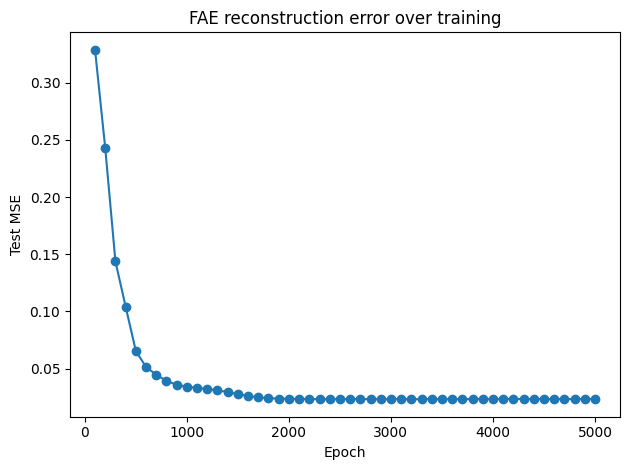

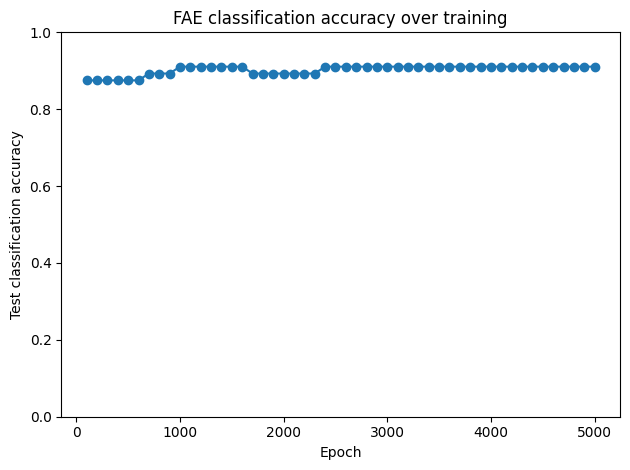

In [5]:
import numpy as np
import matplotlib.pyplot as plt

test_mse_mean = [np.mean(v) for v in history["per_epoch_test_recon_loss"]]
test_mse_sd   = [np.std(v)  for v in history["per_epoch_test_recon_loss"]]

test_acc_mean = [np.mean(v) for v in history["per_epoch_test_class_acc"]]
test_acc_sd   = [np.std(v)  for v in history["per_epoch_test_class_acc"]]

epochs_grid = np.arange(100, len(test_mse_mean)*100 + 1, 100)

plt.figure()
plt.errorbar(epochs_grid, test_mse_mean, yerr=test_mse_sd, fmt='-o', capsize=3)
plt.xlabel('Epoch')
plt.ylabel('Test MSE')
plt.title('FAE reconstruction error over training')
plt.tight_layout()
plt.show()

plt.figure()
plt.errorbar(epochs_grid, test_acc_mean, yerr=test_acc_sd, fmt='-o', capsize=3)
plt.xlabel('Epoch')
plt.ylabel('Test classification accuracy')
plt.ylim(0, 1)
plt.title('FAE classification accuracy over training')
plt.tight_layout()
plt.show()

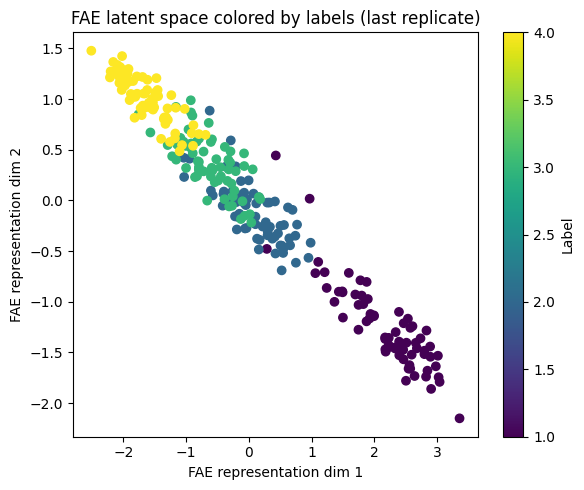

In [6]:
import matplotlib.pyplot as plt
import numpy as np

extras = history["extras"]
model = extras["model"]
loss_fn = extras["loss_fn"]
device = extras["device"]
tpts = extras["tpts"]
basis_fc_project = extras["basis_fc_project"]
basis_fc_revert = extras["basis_fc_revert"]

FAE_pred_all, FAE_reps_all, _, _ = evaluate(model, x, loss_fn, device, tpts, basis_fc_project, basis_fc_revert)

z = FAE_reps_all.detach().cpu().numpy()
lbl = np.asarray(label)

plt.figure(figsize=(6, 5))
sc = plt.scatter(z[:, 0], z[:, 1], c=lbl, cmap='viridis')
plt.xlabel('FAE representation dim 1')
plt.ylabel('FAE representation dim 2')
plt.title('FAE latent space colored by labels (last replicate)')
plt.colorbar(sc, label='Label')
plt.tight_layout()
plt.show()

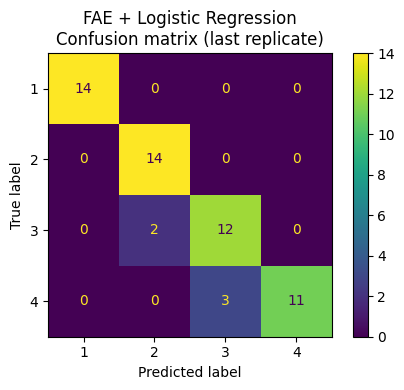

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

extras = history["extras"]
TrainData = extras["TrainData"]
TestData = extras["TestData"]
TrainLabel = extras["TrainLabel"]
TestLabel = extras["TestLabel"]
model = extras["model"]
loss_fn = extras["loss_fn"]
device = extras["device"]
tpts = extras["tpts"]
basis_fc_project = extras["basis_fc_project"]
basis_fc_revert = extras["basis_fc_revert"]

_, reps_train, _, _ = evaluate(model, TrainData, loss_fn, device, tpts, basis_fc_project, basis_fc_revert)
_, reps_test,  _, _ = evaluate(model, TestData,  loss_fn, device, tpts, basis_fc_project, basis_fc_revert)

clf = LogisticRegression(solver="lbfgs", max_iter=2000, random_state=0)
clf.fit(reps_train.detach().cpu().numpy(), TrainLabel)

y_test_pred = clf.predict(reps_test.detach().cpu().numpy())

classes = np.unique(np.concatenate([TestLabel, y_test_pred]))
cm = confusion_matrix(TestLabel, y_test_pred, labels=classes)

fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(ax=ax)
ax.set_title('FAE + Logistic Regression\nConfusion matrix (last replicate)')
plt.tight_layout()
plt.show()


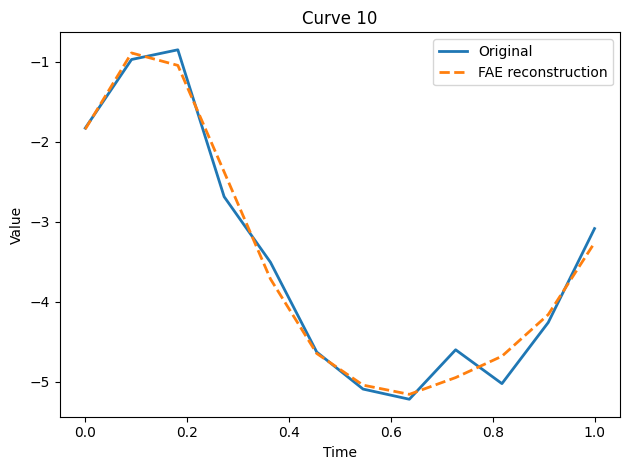

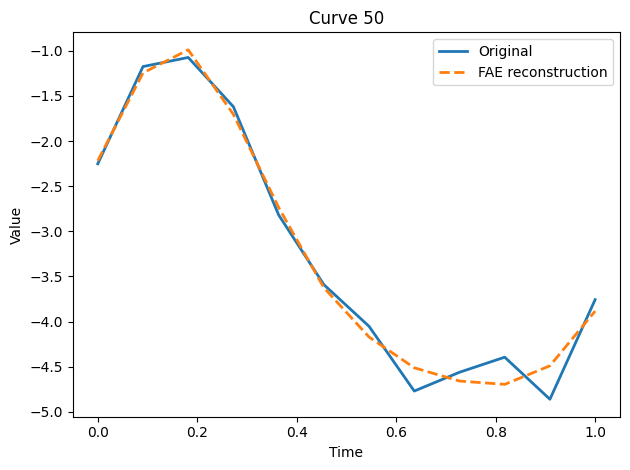

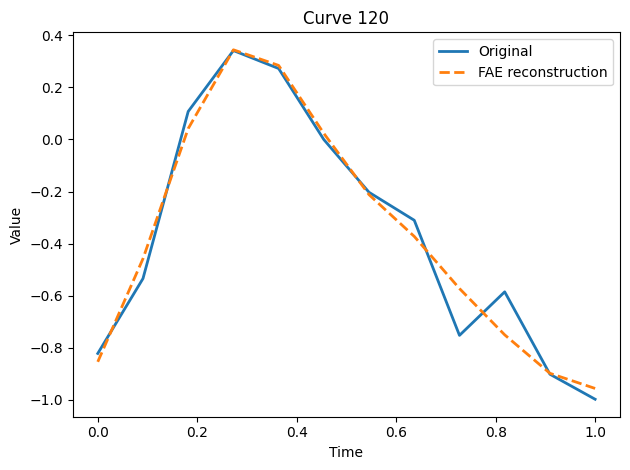

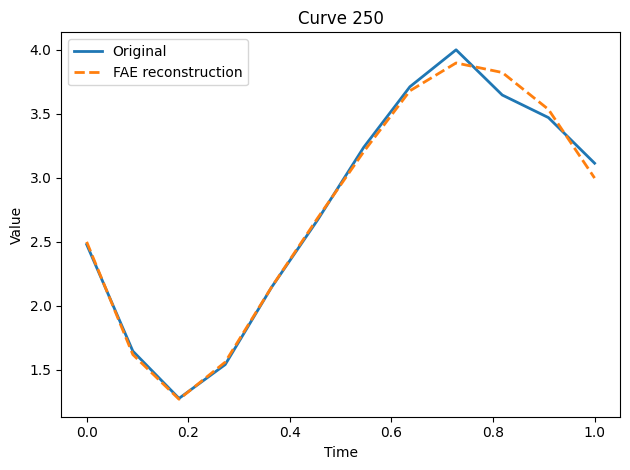

In [8]:
import matplotlib.pyplot as plt
import numpy as np

extras = history["extras"]
model = extras["model"]
loss_fn = extras["loss_fn"]
device = extras["device"]
tpts = extras["tpts"]
basis_fc_project = extras["basis_fc_project"]
basis_fc_revert = extras["basis_fc_revert"]

FAE_pred_all, _, _, _ = evaluate(model, x, loss_fn, device, tpts, basis_fc_project, basis_fc_revert)

t = tpts.detach().cpu().numpy().flatten()
idx_list = [10, 50, 120, 250]

for idx in idx_list:
    orig = x[idx].detach().cpu().numpy()
    recon = FAE_pred_all[idx].detach().cpu().numpy()

    plt.figure()
    plt.plot(t, orig, label='Original', linewidth=2)
    plt.plot(t, recon, '--', label='FAE reconstruction', linewidth=2)
    plt.title(f'Curve {idx}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()
    plt.show()
